<a href="https://colab.research.google.com/github/FarrelAD/Computer-Vision-Case-Method/blob/main/notebooks/Training_Pretrained_Model.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 1. Preparation

In [ ]:
import os
import random
import shutil
import csv
import cv2
from pathlib import Path
from PIL import Image, ExifTags
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    average_precision_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from IPython.display import display

# 2. Data Loading

Opsi 2: Melalui file CSV

In [2]:
df = pd.read_csv('../output/metadata.csv')

display(df.head(20))

display(df.describe())

display(df.info())

,filename,label,bank_name,edit_type,edit_severity,image_source,width,height,has_exif,exif_software,note
0,g_001.png,0,Bank BNI,none,NaN,camera,1080,2540,0,NaN,NaN
1,g_002.png,0,Bank BNI,none,NaN,camera,1080,2540,0,NaN,NaN
2,g_003.png,0,Bank BNI,none,NaN,camera,1080,2540,0,NaN,NaN
3,g_004.png,0,Bank BNI,none,NaN,camera,1080,1697,0,NaN,NaN
4,g_005.png,0,Bank BNI,none,NaN,camera,1080,1697,0,NaN,NaN
5,g_006.png,0,Bank BNI,none,NaN,camera,1080,1697,0,NaN,NaN
6,g_007.png,0,Bank BNI,none,NaN,camera,1080,1587,0,NaN,NaN
7,g_008.png,0,Bank BNI,none,NaN,camera,1080,2540,0,NaN,NaN
8,g_009.png,0,Bank BNI,none,NaN,camera,1080,1587,0,NaN,NaN
9,g_010.png,0,Bank BNI,none,NaN,camera,1080,1697,0,NaN,NaN


,label,width,height,has_exif,exif_software,note
count,96.000000,96.000000,96.000000,96.0,0.0,0.0
mean,0.260417,1059.989583,2251.989583,0.0,NaN,NaN
std,0.441166,85.822153,545.371462,0.0,NaN,NaN
min,0.000000,530.000000,1256.000000,0.0,NaN,NaN
25%,0.000000,1080.000000,1680.250000,0.0,NaN,NaN
50%,0.000000,1080.000000,2540.000000,0.0,NaN,NaN
75%,1.000000,1080.000000,2606.000000,0.0,NaN,NaN
max,1.000000,1196.000000,3327.000000,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       96 non-null     object 
 1   label          96 non-null     int64  
 2   bank_name      96 non-null     object 
 3   edit_type      96 non-null     object 
 4   edit_severity  25 non-null     object 
 5   image_source   96 non-null     object 
 6   width          96 non-null     int64  
 7   height         96 non-null     int64  
 8   has_exif       96 non-null     int64  
 9   exif_software  0 non-null      float64
 10  note           0 non-null      float64
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ KB


None

# 3. Preprocessing

Proses yang bisa dilakukan pada tahapan preprocessing:
- Data augmentation
- Auto crop
- Standardisasi ukuran / aspek rasio
- Contrast & illumination correction

# 4. Data Splitting

In [ ]:
train_df, test_df = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=42)
print("Train:", len(train_df), "Test:", len(test_df))

# 4. Feature Extraction

In [ ]:
# features = pd.read_csv("data/features.csv").merge(df, on="filename")
# features.to_csv("data/train_ready.csv", index=False)

# 5. Modelling

In [ ]:
class ReceiptDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform or transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["filename"]
        img = Image.open(img_path).convert("RGB")
        x = self.transform(img)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return x, y

train_ds = ReceiptDataset(train_df, "../input/images_dataset/")
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)


In [ ]:
def make_model() -> models.ResNet:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification
    return model


# 6. Model Training

In [ ]:
model = make_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

opt = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
        preds = model(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dl):.4f}")


c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5154
Epoch 2, Loss: 0.4523
Epoch 3, Loss: 0.3253
Epoch 4, Loss: 0.2075
Epoch 5, Loss: 0.2241


# 7. Model Evaluation and Validation

In [ ]:
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for imgs, labels in DataLoader(ReceiptDataset(test_df, "../input/images_dataset/"), batch_size=8):
        imgs = imgs.to(device)
        preds = model(imgs).cpu().squeeze()
        probs = torch.sigmoid(preds)
        all_probs.extend(probs.numpy())
        all_preds.extend((probs > 0.5).int().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))
print("PR-AUC:", average_precision_score(all_labels, all_probs))


              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        15
         1.0       1.00      0.20      0.33         5

    accuracy                           0.80        20
   macro avg       0.89      0.60      0.61        20
weighted avg       0.84      0.80      0.75        20

PR-AUC: 0.6458333333333333


Didapatkan akurasi $80\%$

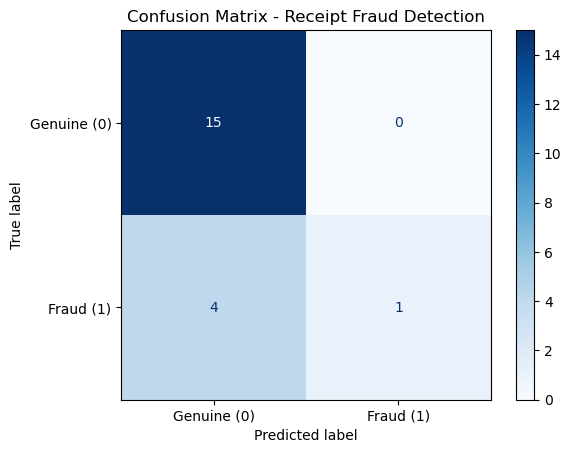

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine (0)", "Fraud (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Receipt Fraud Detection")
plt.show()


# 8. Testing

In [ ]:
# Define the same transform used in training
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Load image
img_path = "../input/bni-receipts/fraud/f_006.png"   # <-- put your own image path here
img = Image.open(img_path).convert("RGB")
x = transform(img).unsqueeze(0).to(device) # type: ignore

# Predict
model.eval()
with torch.no_grad():
    prob = torch.sigmoid(model(x)).item()

print(f"Predicted fraud probability: {prob:.3f}")
if prob > 0.5:
    print("🧾 This receipt is likely FRAUD.")
else:
    print("✅ This receipt looks GENUINE.")


Predicted fraud probability: 0.990
🧾 This receipt is likely FRAUD.
